# Data Analysis (CARTA)

We want to assess the effects on the predictive accuracy of our board and alight count models considering the following two data partitions (and combinations):

* Pre- and post-lockdown.
* Overdispersion based on the mean and variance of the pre-defined groups:
    - `Poisson`
    - `Mean_Greater_Var`
    - `Overdispersed`

|    |      Pre-lockdown      |  Post-lockdown |
|----------|:-------------:|------:|
| Poisson Assumption | Group A1  | Group A2 |
| Mean greater than the Varaiance | Group B1  | Group B2   |
| Overdispersed | Group C1  | Group C2   |


First, we analyze the marginal effects of these partitions. By separating the data based on a drastic change in ridership (Pre and post-lockdown), we will be able to know if we can predict pre- and post-lockdown data. We will compare the training and testing MSEs of the models without the partition versus the training and testing MSEs of the models with the partition.

Besides that, we are also assuming that the board and alight counts (grouped by day of the week, route, direction, stop id) follow Poisson distributions whose parameters indicate their hourly mean, we will be able to know if grouping the data based on the Poisson assumption -mean is (approximately) equal to variance- improves the predictive accuracy of the models. Similarly, this task requires comparing the model's MSEs with and without the grouping or classification according to the Poisson assumption.

Moreover, we will analyze the combined effect of these two data partitions on the models' performance. This will allow us to know the optimum machine learning pipeline (data classification + model regressions) for parametric regressions such as Poisson, Quasi-Poisson, Negative-Binomial, Zero-inflated, and Hurdle regression models.

On the other hand, we will identify the data characteristics that require approaches with higher flexibility, such as Neural Networks. The obtained results and conclusions will help modelers (and decision-makers) to improve the accuracy and interpretability of parametric models by proposing model pipelines for the board and alight counts.


# On Predictive Pipelines for Estimating the Expected Boarding and Alighting and Occupancy Count for Public Transit Systems

## Abstract

Fine-grained ridership forecasting is important for providing guidance to commuters, and performing operational optimization for public transit, especially during pandemic. Traditional approaches to modeling the underlying random processes fail to learn accurate dynamics and covariate determinants because of the wide variances, over dispersion (i.e., variances are greater than the mean) and zero counts in the available automated passenger count for the transit vehicles. This is partially due to the affect the pandemic has had on ridership patterns. Our contribution in this paper is to present a predictive pipeline that solves these problems and prevents a comparative analysis of several modeling strategies including Poisson, Quasi-Poisson, Negative-Binomial, Zero inflated Poisson, hurdle-models, and neural networks. Our innovation lies in the automatic partitioning of data into bins that are created not only on the basis of the route structure, stops, day of the week, direction but also using the degree of over dispersion (mean close to variance i.e., Poisson, variance greater than the mean and mean greater than the variance) and the homogeneity of the mean across sliding time windows. We further identify the optimal predictive model and describe an automated mechanism for selecting the models. The obtained results and conclusions will help modelers (and decision-makers) to improve the accuracy and interpretability of parametric models by proposing model pipelines for the board and alight counts and choose the appropriate model for real-time prediction. We present results using the data from two large communities in USA and compare our results against single models that are prevalent in the state of the art.


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn import tree

The following data is the latest version of the CARTA data set. It is the data that was processed by Mike during Dec-2020 and uploaded on January 4 2021 (01-04-2021). The data can be found in the following folder in Teams:

* General > datasets > carta-occupancy > app-data:
    * cartaapac_dashboard.csv.zip 
    

In [2]:
carta = pd.read_csv('cartaapc_dashboard.zip')

In [3]:
total_num_rows = carta.shape[0]

In [4]:
carta.stop_id = carta['stop_id'].astype(str)
carta.route_id = carta['route_id'].astype(str)
carta.service_period = carta['service_period'].astype(str)
carta.hour = carta['hour'].astype(str)

In [5]:
carta.trip_date = pd.to_datetime(carta['trip_date'], format="%Y-%m-%d")
carta.trip_start_time = pd.to_datetime(carta['trip_start_time'], format="%H:%M:%S")
carta.date_time = pd.to_datetime(carta['date_time'], format = "%Y-%m-%d %H:%M:%S")
carta.date = pd.to_datetime(carta['date'], format = "%Y-%m-%d")
carta.arrival_time = pd.to_datetime(carta['arrival_time'], format = "%H:%M:%S")

In [6]:
carta['month'] = carta['date'].dt.month
carta.month = carta['month'].astype(str)
carta.hour = carta['hour'].astype(str)

In [7]:
carta = carta.dropna(axis = 0)

*I used all the routes, but they can be easily filter as follows:*

- `data_filter_by_routeX = carta[carta['route_id] == 'routeX']`

*Similarly, with the `stop_id`s.

In [8]:
carta.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,alight_count,occupancy,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139145,1900-01-01 08:51:00,354,1,35.056167,-85.268713,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:51:00,1900-01-01 08:51:00,4,2019-11-01,8,11
1,139145,1900-01-01 08:54:59,505,2,35.056017,-85.281080,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:54:59,1900-01-01 08:51:00,4,2019-11-01,8,11
2,139145,1900-01-01 09:05:00,1713,3,35.042000,-85.308670,16,0,1,1,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:00,1900-01-01 08:51:00,4,2019-11-01,9,11
3,139145,1900-01-01 09:05:21,1560,4,35.042880,-85.309102,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:21,1900-01-01 08:51:00,4,2019-11-01,9,11
4,139145,1900-01-01 09:05:39,163,5,35.043448,-85.309277,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:39,1900-01-01 08:51:00,4,2019-11-01,9,11


In [9]:
carta.route_id.unique()

array(['16', '9', '1', '10G', '10A', '7', '19', '3', '10C', '13', '4',
       '2', '21', '28', '8', '15'], dtype=object)

## Pre and post lockdown

From Mike's paper: "Chattanooga’s steep decline started the week of **March 5th** before hitting a low also on the week of April 19 with a low of 8,077 weekly riders." 

Text(0, 0.5, 'Alight Count')

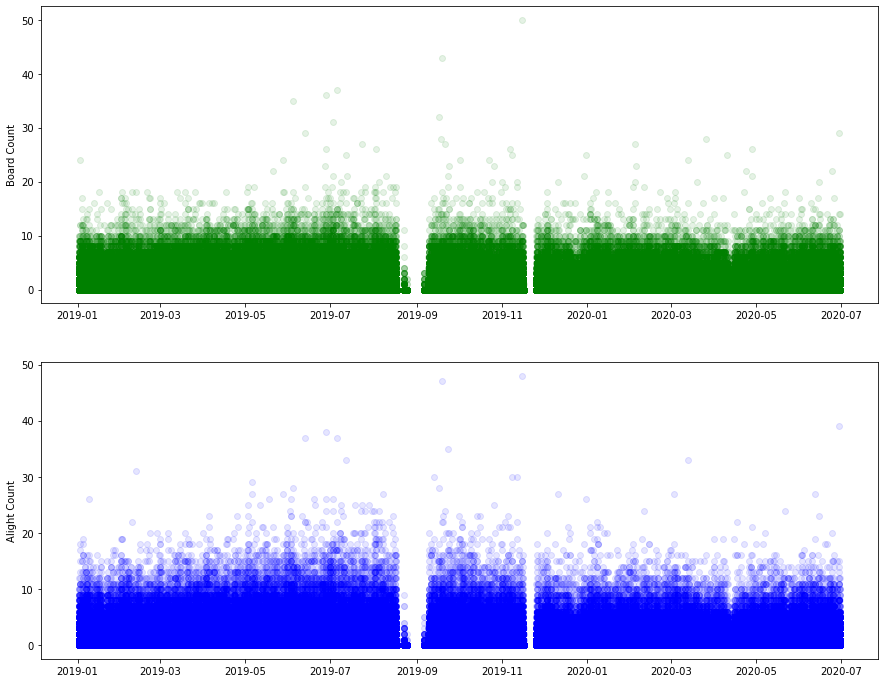

In [10]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(carta.date, carta.board_count, 'o', alpha = 0.1, color = 'green')
plt.ylabel('Board Count')

plt.subplot(2,1,2)
plt.plot(carta.date, carta.alight_count, 'o', alpha = 0.1, color = 'blue')
plt.ylabel('Alight Count')


Therefore, we subdivide the data using '2019-03-05':

* Pre-lockdown: `Pre_lock`
* Post-lockdown: `Post_lock`

### Pre-lockdown

In [11]:
# Pre-lockdown
Pre_lock = carta[carta['date'] <= '2019-03-05']

In [12]:
Pre_lock.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,alight_count,occupancy,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
390047,134679,1900-01-01 08:41:00,354,1,35.056167,-85.268713,7,1,0,0,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:41:00,1900-01-01 08:41:00,2,2019-01-02,8,1
390048,134679,1900-01-01 08:41:06,355,2,35.055130,-85.269413,7,1,0,0,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:41:06,1900-01-01 08:41:00,2,2019-01-02,8,1
390049,134679,1900-01-01 08:41:12,356,3,35.054760,-85.270430,7,1,0,0,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:41:12,1900-01-01 08:41:00,2,2019-01-02,8,1
390050,134679,1900-01-01 08:42:03,358,4,35.049015,-85.277107,7,1,0,0,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:42:03,1900-01-01 08:41:00,2,2019-01-02,8,1
390051,134679,1900-01-01 08:43:10,359,5,35.046412,-85.278505,7,1,0,0,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:43:10,1900-01-01 08:41:00,2,2019-01-02,8,1


In [13]:
Pre_lock.shape

(1507284, 20)

### Post-lockdown

In [14]:
# Pre-lockdown
Post_lock = carta[carta['date'] > '2019-03-05']

In [15]:
Post_lock.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,alight_count,occupancy,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139145,1900-01-01 08:51:00,354,1,35.056167,-85.268713,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:51:00,1900-01-01 08:51:00,4,2019-11-01,8,11
1,139145,1900-01-01 08:54:59,505,2,35.056017,-85.281080,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:54:59,1900-01-01 08:51:00,4,2019-11-01,8,11
2,139145,1900-01-01 09:05:00,1713,3,35.042000,-85.308670,16,0,1,1,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:00,1900-01-01 08:51:00,4,2019-11-01,9,11
3,139145,1900-01-01 09:05:21,1560,4,35.042880,-85.309102,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:21,1900-01-01 08:51:00,4,2019-11-01,9,11
4,139145,1900-01-01 09:05:39,163,5,35.043448,-85.309277,16,0,0,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:05:39,1900-01-01 08:51:00,4,2019-11-01,9,11


In [16]:
Post_lock.shape

(8868607, 20)

The partition implies that there is not any row in both groups, or the sum of the their respective number of rows minus the total number of rows should equal to zero.

In [17]:
Pre_lock.shape[0] + Post_lock.shape[0] - total_num_rows

0

Therefore, this partition (pre- and post-lockdown) does not have overlaps.

## Overdispersion

- *The idea behind this classification process is based on the Poisson assumption which states that the mean is (approximately) equal to the variance. *

We propose three groups for the data according to the following characteristics:

* `Poisson`:  Group's mean is (approximately) equal to the group's variance.
* `Overdispersion`: Group's mean is less than the group's variance.
* `Mean_Greater_Var`: Group's mean is greater than the group's variance.

Since *approximately* can be subjective, I propose to use an arbitrary tolerance value $(\epsilon = 0.25)$ to quantify it. Also, a **group** ($\mathcal{G}$) is just the set of dependent variables $Y$ (board or alight counts) with the same `route_id`, `direction_id`, `stop_id`, and `day_of_week`. The mean and variance of the a set are given by $mean(\mathcal{G_{Y}})$ and $var(\mathcal{G_{Y}})$, respectively. Therefore, a group $\mathcal{G}$ will be labeled as `Poisson` if and only if:

\begin{equation}
    1-\epsilon \leq \frac{mean(\mathcal{G_{Y}})}{var(\mathcal{G_{Y}})} \leq 1 + \epsilon
\end{equation}

The `Overdispersion` groups have the following characteristics:

\begin{equation}
    0 \leq \frac{mean(\mathcal{G_{Y}})}{var(\mathcal{G_{Y}})} \leq 1 - \epsilon
\end{equation}

Finally, the `Mean_Greater_Var` groups are characterized by the following characteristic:

\begin{equation}
    \frac{mean(\mathcal{G_{Y}})}{var(\mathcal{G_{Y}})} > 1 + \epsilon
\end{equation}

First, let's create a new dataframe `X` to group the whole data set:

In [18]:
X = carta[['route_id', 'stop_id', 'direction_id', 'day_of_week',  'board_count', 'alight_count']]
X.head()

,route_id,stop_id,direction_id,day_of_week,board_count,alight_count
0,16,354,0,4,0,0
1,16,505,0,4,0,0
2,16,1713,0,4,1,1
3,16,1560,0,4,0,0
4,16,163,0,4,0,0


In [19]:
X_dt = X.groupby(['route_id', 'direction_id', 'stop_id', 'day_of_week']).agg(['mean', 'var'])

In [20]:
X_dt.head()

board_count           alight_count  \
                                                 mean       var         mean   
route_id direction_id stop_id day_of_week                                      
1        0            12      0              0.835676  2.148213     0.608649   
                              1              0.863521  2.230603     0.568239   
                              2              0.885626  2.405469     0.530139   
                              3              0.801531  2.061792     0.470749   
                              4              0.914144  2.212585     0.482878   

                                                     
                                                var  
route_id direction_id stop_id day_of_week            
1        0            12      0            1.363257  
                              1            1.342930  
                              2            1.209014  
                              3            0.919959  
                              4            0.943972

In [21]:
X_dt.shape

(11853, 4)

This mean that there are 11853 groups in the whole data set.

In [22]:
X_DF = X_dt.reset_index(level = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
X_DF.head()

route_id direction_id stop_id day_of_week board_count            \
                                                   mean       var   
0        1            0      12           0    0.835676  2.148213   
1        1            0      12           1    0.863521  2.230603   
2        1            0      12           2    0.885626  2.405469   
3        1            0      12           3    0.801531  2.061792   
4        1            0      12           4    0.914144  2.212585   

  alight_count            
          mean       var  
0     0.608649  1.363257  
1     0.568239  1.342930  
2     0.530139  1.209014  
3     0.470749  0.919959  
4     0.482878  0.943972

In [23]:
X_DF.columns = ['route_id', 'direction_id', 'stop_id', 'day_of_week', 'board_mean', 'board_var', 'alight_mean', 'alight_var']

In [24]:
X_DF.head()

,route_id,direction_id,stop_id,day_of_week,board_mean,board_var,alight_mean,alight_var
0,1,0,12,0,0.835676,2.148213,0.608649,1.363257
1,1,0,12,1,0.863521,2.230603,0.568239,1.342930
2,1,0,12,2,0.885626,2.405469,0.530139,1.209014
3,1,0,12,3,0.801531,2.061792,0.470749,0.919959
4,1,0,12,4,0.914144,2.212585,0.482878,0.943972


In [25]:
X_DF['Broad_Overdispersion'] = X_DF['board_mean']/(X_DF['board_var'])
X_DF['Alight_Overdispersion'] = X_DF['alight_mean']/(X_DF['alight_var'])

In [26]:
X_DF.head()

,route_id,direction_id,stop_id,day_of_week,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion
0,1,0,12,0,0.835676,2.148213,0.608649,1.363257,0.389010,0.446467
1,1,0,12,1,0.863521,2.230603,0.568239,1.342930,0.387125,0.423134
2,1,0,12,2,0.885626,2.405469,0.530139,1.209014,0.368172,0.438489
3,1,0,12,3,0.801531,2.061792,0.470749,0.919959,0.388754,0.511707
4,1,0,12,4,0.914144,2.212585,0.482878,0.943972,0.413156,0.511539


In [27]:
Poiss_Assump_Board = []

for i in X_DF['Broad_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Board.append(condition)

In [28]:
Poiss_Assump_Alight = []

for i in X_DF['Alight_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Alight.append(condition)

In [29]:
X_DF['Poiss_Assump_Board'] = Poiss_Assump_Board
X_DF['Poiss_Assump_Alight'] = Poiss_Assump_Alight

In [30]:
X_DF.head(20)

,route_id,direction_id,stop_id,day_of_week,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion,Poiss_Assump_Board,Poiss_Assump_Alight
0,1,0,12,0,0.835676,2.148213,0.608649,1.363257,0.389010,0.446467,Overdispersion,Overdispersion
1,1,0,12,1,0.863521,2.230603,0.568239,1.342930,0.387125,0.423134,Overdispersion,Overdispersion
2,1,0,12,2,0.885626,2.405469,0.530139,1.209014,0.368172,0.438489,Overdispersion,Overdispersion
3,1,0,12,3,0.801531,2.061792,0.470749,0.919959,0.388754,0.511707,Overdispersion,Overdispersion
4,1,0,12,4,0.914144,2.212585,0.482878,0.943972,0.413156,0.511539,Overdispersion,Overdispersion
5,1,0,12,5,0.629230,1.427992,0.421166,0.840503,0.440639,0.501089,Overdispersion,Overdispersion
6,1,0,12,6,0.816872,2.104539,0.596708,1.771041,0.388148,0.336925,Overdispersion,Overdispersion
7,1,0,1351,0,0.512432,1.135865,0.016757,0.028383,0.451139,0.590376,Overdispersion,Overdispersion
8,1,0,1351,1,0.482496,0.987891,0.016743,0.025608,0.488410,0.653814,Overdispersion,Overdispersion
9,1,0,1351,2,0.496651,0.977953,0.018547,0.024398,0.507848,0.760188,Overdispersion,Poisson


The first row (`*.iloc[0]`) indicates that according to our classification or grouping conditions, on Mondays (`day_of_week = 0`), the board and alight count data from `route_id = 1`,  `direction_id = 0`, `stop_id = 12` are overdispersed.

In [31]:
X_DF_rows = X_DF.shape[0]
X_DF_rows

11853

### Grouping Pre-lockdown data

In [32]:
Pre_lockX = Pre_lock[['route_id', 'direction_id', 'stop_id', 'day_of_week', 'board_count', 'alight_count']]
Pre_lockX_dt = Pre_lockX.groupby(['route_id', 'direction_id', 'stop_id', 'day_of_week']).agg(['mean', 'var'])
Pre_lockX_DF = Pre_lockX_dt.reset_index(level = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Pre_lockX_DF.columns = ['route_id', 'direction_id', 'stop_id', 'day_of_week', 'board_mean', 'board_var', 'alight_mean', 'alight_var']
Pre_lockX_DF.head()

,route_id,direction_id,stop_id,day_of_week,board_mean,board_var,alight_mean,alight_var
0,1,0,12,0,1.015564,2.812257,0.754864,2.006080
1,1,0,12,1,1.084459,2.965724,0.577703,1.492247
2,1,0,12,2,1.150685,3.324295,0.606164,1.387316
3,1,0,12,3,1.128906,3.014691,0.445312,0.977390
4,1,0,12,4,0.924731,1.681365,0.587814,1.063304


In [33]:
Pre_lockX_DF.shape

(11042, 8)

We get 11402 different groups for the Pre-lockdown data set. 

In [34]:
Pre_lockX_DF['Broad_Overdispersion'] = Pre_lockX_DF['board_mean']/(Pre_lockX_DF['board_var'])
Pre_lockX_DF['Alight_Overdispersion'] = Pre_lockX_DF['alight_mean']/(Pre_lockX_DF['alight_var'])

In [35]:
Poiss_Assump_Board = []

for i in Pre_lockX_DF['Broad_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Board.append(condition)

In [36]:
Poiss_Assump_Alight = []

for i in Pre_lockX_DF['Alight_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Alight.append(condition)

In [37]:
Pre_lockX_DF['Poiss_Assump_Board'] = Poiss_Assump_Board
Pre_lockX_DF['Poiss_Assump_Alight'] = Poiss_Assump_Alight

In [38]:
Pre_lockX_DF.head(20)

,route_id,direction_id,stop_id,day_of_week,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion,Poiss_Assump_Board,Poiss_Assump_Alight
0,1,0,12,0,1.015564,2.812257,0.754864,2.006080,0.361121,0.376288,Overdispersion,Overdispersion
1,1,0,12,1,1.084459,2.965724,0.577703,1.492247,0.365664,0.387136,Overdispersion,Overdispersion
2,1,0,12,2,1.150685,3.324295,0.606164,1.387316,0.346144,0.436933,Overdispersion,Overdispersion
3,1,0,12,3,1.128906,3.014691,0.445312,0.977390,0.374468,0.455614,Overdispersion,Overdispersion
4,1,0,12,4,0.924731,1.681365,0.587814,1.063304,0.549988,0.552818,Overdispersion,Overdispersion
5,1,0,12,5,0.541063,0.832044,0.309179,0.554430,0.650282,0.557652,Overdispersion,Overdispersion
6,1,0,12,6,0.845070,1.789940,0.394366,0.813682,0.472122,0.484669,Overdispersion,Overdispersion
7,1,0,1351,0,0.435798,0.864026,0.000000,0.000000,0.504380,NaN,Overdispersion,Poisson
8,1,0,1351,1,0.540541,1.327164,0.006757,0.013514,0.407290,0.500000,Overdispersion,Overdispersion
9,1,0,1351,2,0.452055,0.798381,0.017123,0.016888,0.566215,1.013937,Overdispersion,Poisson


In [39]:
Pre_lockX_DF.shape

(11042, 12)

## Grouping Post-lockdown data

In [40]:
Post_lockX = Post_lock[['route_id', 'direction_id', 'stop_id', 'day_of_week', 'board_count', 'alight_count']]
Post_lockX_dt = Post_lockX.groupby(['route_id', 'direction_id', 'stop_id', 'day_of_week']).agg(['mean', 'var'])
Post_lockX_DF = Post_lockX_dt.reset_index(level = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Post_lockX_DF.columns = ['route_id', 'direction_id', 'stop_id', 'day_of_week', 'board_mean', 'board_var', 'alight_mean', 'alight_var']

Post_lockX_DF['Broad_Overdispersion'] = Post_lockX_DF['board_mean']/(Post_lockX_DF['board_var'])
Post_lockX_DF['Alight_Overdispersion'] = Post_lockX_DF['alight_mean']/(Post_lockX_DF['alight_var'])

In [41]:
Poiss_Assump_Board = []

for i in Post_lockX_DF['Broad_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Board.append(condition)

In [42]:
Poiss_Assump_Alight = []

for i in Post_lockX_DF['Alight_Overdispersion']:
    if i > 1.25:
        condition = 'Mean_Greater_Var'
    elif i < 0.75:
        condition = 'Overdispersion'
    else:
        condition = 'Poisson'
    Poiss_Assump_Alight.append(condition)

In [43]:
Post_lockX_DF['Poiss_Assump_Board'] = Poiss_Assump_Board
Post_lockX_DF['Poiss_Assump_Alight'] = Poiss_Assump_Alight

In [44]:
Post_lockX_DF.head(20)

,route_id,direction_id,stop_id,day_of_week,board_mean,board_var,alight_mean,alight_var,Broad_Overdispersion,Alight_Overdispersion,Poiss_Assump_Board,Poiss_Assump_Alight
0,1,0,12,0,0.806654,2.036714,0.585060,1.256736,0.396057,0.465539,Overdispersion,Overdispersion
1,1,0,12,1,0.824478,2.092232,0.566567,1.317400,0.394066,0.430065,Overdispersion,Overdispersion
2,1,0,12,2,0.838690,2.230031,0.516677,1.177058,0.376089,0.438956,Overdispersion,Overdispersion
3,1,0,12,3,0.748252,1.888236,0.474889,0.911106,0.396270,0.521222,Overdispersion,Overdispersion
4,1,0,12,4,0.912442,2.298957,0.466014,0.923340,0.396894,0.504704,Overdispersion,Overdispersion
5,1,0,12,5,0.644670,1.531551,0.440778,0.888530,0.420926,0.496076,Overdispersion,Overdispersion
6,1,0,12,6,0.812048,2.162656,0.631325,1.928968,0.375486,0.327287,Overdispersion,Overdispersion
7,1,0,1351,0,0.524796,1.179190,0.019460,0.032913,0.445048,0.591269,Overdispersion,Overdispersion
8,1,0,1351,1,0.472239,0.927992,0.018507,0.027734,0.508882,0.667327,Overdispersion,Overdispersion
9,1,0,1351,2,0.504548,1.009840,0.018799,0.025739,0.499632,0.730392,Overdispersion,Overdispersion


## Group A1: Pre-lockdown and Poisson Assumption

### Board Counts

In [45]:
Group_A1_board_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Board'] == 'Poisson']
Group_A1_board_index = Group_A1_board_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_A1_board_index.head(10)

In [47]:
Group_A1_board_index.shape

(7292, 4)

In [49]:
Group_A1_board = pd.merge(Pre_lock, Group_A1_board_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_A1_board = Group_A1_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_A1_board.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,134679,1900-01-01 08:41:06,355,2,35.05513,-85.269413,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:41:06,1900-01-01 08:41:00,2,2019-01-02,8,1
1,135623,1900-01-01 07:46:06,355,2,35.05513,-85.269413,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 07:46:06,1900-01-01 07:46:00,2,2019-01-02,7,1
2,134675,1900-01-01 04:41:06,355,2,35.05513,-85.269413,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 04:41:06,1900-01-01 04:41:00,2,2019-01-02,4,1
3,134677,1900-01-01 15:01:06,355,2,35.05513,-85.269413,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 15:01:06,1900-01-01 15:01:00,2,2019-01-02,15,1
4,135624,1900-01-01 09:26:06,355,2,35.05513,-85.269413,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 09:26:06,1900-01-01 09:26:00,2,2019-01-02,9,1


In [50]:
Group_A1_board.shape

(757504, 18)

### Alight Counts

In [51]:
Group_A1_alight_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Alight'] == 'Poisson']
Group_A1_alight_index = Group_A1_alight_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_A1_alight_index.head()

,route_id,direction_id,stop_id,day_of_week
7,1,0,1351,0
9,1,0,1351,2
12,1,0,1351,5
13,1,0,1351,6
21,1,0,1354,0


In [52]:
Group_A1_alight_index.shape

(7391, 4)

In [53]:
Group_A1_alight = pd.merge(Pre_lock, Group_A1_alight_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_A1_alight = Group_A1_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_A1_alight.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,134679,1900-01-01 08:41:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:41:00,1900-01-01 08:41:00,2,2019-01-02,8,1
1,135623,1900-01-01 07:46:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 07:46:00,1900-01-01 07:46:00,2,2019-01-02,7,1
2,134675,1900-01-01 04:41:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 04:41:00,1900-01-01 04:41:00,2,2019-01-02,4,1
3,134677,1900-01-01 15:01:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 15:01:00,1900-01-01 15:01:00,2,2019-01-02,15,1
4,135624,1900-01-01 09:26:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 09:26:00,1900-01-01 09:26:00,2,2019-01-02,9,1


In [54]:
Group_A1_alight.shape

(799546, 18)

## Group A2: Post-lockdown and Poisson Assumption

### Board Counts

In [56]:
Group_A2_board_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Board'] == 'Poisson']
Group_A2_board_index = Group_A2_board_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_A2_board_index.head()

,route_id,direction_id,stop_id,day_of_week
65,1,0,18,2
66,1,0,18,3
81,1,0,21,4
88,1,0,22,4
90,1,0,22,6


In [57]:
Group_A2_board = pd.merge(Post_lock, Group_A2_board_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_A2_board = Group_A2_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_A2_board.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139145,1900-01-01 09:06:34,165,7,35.046062,-85.30934,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:06:34,1900-01-01 08:51:00,4,2019-11-01,9,11
1,139146,1900-01-01 11:16:32,165,5,35.046062,-85.30934,16,0,1,OUTBOUND,Weekday,2019-11-01,2019-11-01 11:16:32,1900-01-01 11:15:00,4,2019-11-01,11,11
2,139122,1900-01-01 06:01:32,165,5,35.046062,-85.30934,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 06:01:32,1900-01-01 06:00:00,4,2019-11-01,6,11
3,139126,1900-01-01 08:11:32,165,5,35.046062,-85.30934,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:11:32,1900-01-01 08:10:00,4,2019-11-01,8,11
4,139128,1900-01-01 10:16:32,165,5,35.046062,-85.30934,16,0,1,OUTBOUND,Weekday,2019-11-01,2019-11-01 10:16:32,1900-01-01 10:15:00,4,2019-11-01,10,11


In [58]:
Group_A2_board.shape

(2116095, 18)

### Alight Counts

In [59]:
Group_A2_alight_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Alight'] == 'Poisson']
Group_A2_alight_index = Group_A2_alight_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_A2_alight_index.head()

,route_id,direction_id,stop_id,day_of_week
12,1,0,1351,5
26,1,0,1354,5
28,1,0,1357,0
29,1,0,1357,1
30,1,0,1357,2


In [60]:
Group_A2_alight = pd.merge(Post_lock, Group_A2_alight_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_A2_alight = Group_A2_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_A2_alight.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139145,1900-01-01 08:51:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:51:00,1900-01-01 08:51:00,4,2019-11-01,8,11
1,139139,1900-01-01 09:26:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:26:00,1900-01-01 09:26:00,4,2019-11-01,9,11
2,139140,1900-01-01 10:31:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 10:31:00,1900-01-01 10:31:00,4,2019-11-01,10,11
3,139129,1900-01-01 12:01:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 12:01:00,1900-01-01 12:01:00,4,2019-11-01,12,11
4,139147,1900-01-01 12:26:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 12:26:00,1900-01-01 12:26:00,4,2019-11-01,12,11


In [61]:
Group_A2_alight.shape

(2575097, 18)

## Group B1: Pre-lockdown and Mean greater than the variance

### Board Counts

In [62]:
Group_B1_board_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Board'] == 'Mean_Greater_Var']
Group_B1_board_index = Group_B1_board_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_B1_board_index.head(10)

,route_id,direction_id,stop_id,day_of_week
1124,10A,0,505,4
1681,10C,0,1713,0
4599,16,0,505,6
5706,19,1,1044,3
6430,21,0,1351,0
6942,28,0,1351,1
6944,28,0,1351,3
7064,28,1,1555,3
7300,3,0,287,2
7305,3,0,354,1


In [63]:
Group_B1_board = pd.merge(Pre_lock, Group_B1_board_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_B1_board = Group_B1_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_B1_board.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,134383,1900-01-01 07:02:38,1003,2,35.030382,-85.155545,4,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 07:02:38,1900-01-01 07:00:00,2,2019-01-02,7,1
1,134384,1900-01-01 07:37:38,1003,2,35.030382,-85.155545,4,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 07:37:38,1900-01-01 07:35:00,2,2019-01-02,7,1
2,134384,1900-01-01 07:37:38,1003,2,35.030382,-85.155545,4,1,0,INBOUND,Weekday,2019-01-09,2019-01-09 07:37:38,1900-01-01 07:35:00,2,2019-01-09,7,1
3,134383,1900-01-01 07:02:38,1003,2,35.030382,-85.155545,4,1,1,INBOUND,Weekday,2019-01-16,2019-01-16 07:02:38,1900-01-01 07:00:00,2,2019-01-16,7,1
4,134384,1900-01-01 07:37:38,1003,2,35.030382,-85.155545,4,1,0,INBOUND,Weekday,2019-01-16,2019-01-16 07:37:38,1900-01-01 07:35:00,2,2019-01-16,7,1


In [64]:
Group_B1_board.shape

(312, 18)

### Alight Counts

In [65]:
Group_B1_alight_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Alight'] == 'Mean_Greater_Var']
Group_B1_alight_index = Group_B1_alight_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_B1_alight_index.head(10)

,route_id,direction_id,stop_id,day_of_week
920,10A,0,1713,3
4007,13,1,690,2
6323,2,1,1555,0
6825,21,1,690,1
7223,3,0,1746,3
7408,3,1,163,2
7459,3,1,172,5
7474,3,1,1757,2
7563,4,0,1469,0
7696,4,0,1877,2


In [66]:
Group_B1_alight = pd.merge(Pre_lock, Group_B1_alight_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_B1_alight = Group_B1_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_B1_alight.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,134341,1900-01-01 18:35:00,1882,30,35.036783,-85.160408,4,0,2,OUTBOUND,Weekday,2019-01-02,2019-01-02 18:35:00,1900-01-01 17:45:00,2,2019-01-02,18,1
1,134341,1900-01-01 18:35:00,1882,30,35.036783,-85.160408,4,0,1,OUTBOUND,Weekday,2019-01-09,2019-01-09 18:35:00,1900-01-01 17:45:00,2,2019-01-09,18,1
2,134363,1900-01-01 17:45:00,1882,39,35.036783,-85.160408,4,0,1,OUTBOUND,Weekday,2019-01-09,2019-01-09 17:45:00,1900-01-01 16:51:00,2,2019-01-09,17,1
3,134341,1900-01-01 18:35:00,1882,30,35.036783,-85.160408,4,0,1,OUTBOUND,Weekday,2019-01-16,2019-01-16 18:35:00,1900-01-01 17:45:00,2,2019-01-16,18,1
4,134341,1900-01-01 18:35:00,1882,30,35.036783,-85.160408,4,0,0,OUTBOUND,Weekday,2019-01-23,2019-01-23 18:35:00,1900-01-01 17:45:00,2,2019-01-23,18,1


In [67]:
Group_B1_alight.shape

(293, 18)

## Group B2: Post-lockdown and Mean greater than the variance

### Board Counts

In [69]:
Group_B2_board_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Board'] == 'Mean_Greater_Var']
Group_B2_board_index = Group_B2_board_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_B2_board_index.head(10)

,route_id,direction_id,stop_id,day_of_week
8090,3,1,569,0


In [70]:
Group_B2_board = pd.merge(Post_lock, Group_B2_board_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_B2_board = Group_B2_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_B2_board.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,136800,1900-01-01 05:59:34,569,21,35.05158,-85.31057,3,1,0,INBOUND,Weekday,2019-05-06,2019-05-06 05:59:34,1900-01-01 05:20:00,0,2019-05-06,5,5
1,136799,1900-01-01 07:14:34,569,21,35.05158,-85.31057,3,1,0,INBOUND,Weekday,2019-05-13,2019-05-13 07:14:34,1900-01-01 06:35:00,0,2019-05-13,7,5
2,136800,1900-01-01 05:59:34,569,21,35.05158,-85.31057,3,1,0,INBOUND,Weekday,2019-05-20,2019-05-20 05:59:34,1900-01-01 05:20:00,0,2019-05-20,5,5
3,136812,1900-01-01 07:34:41,569,21,35.05158,-85.31057,3,1,0,INBOUND,Saturday,2019-05-27,2019-05-27 07:34:41,1900-01-01 07:05:00,0,2019-05-27,7,5
4,136799,1900-01-01 07:14:34,569,21,35.05158,-85.31057,3,1,0,INBOUND,Weekday,2019-07-01,2019-07-01 07:14:34,1900-01-01 06:35:00,0,2019-07-01,7,7


In [71]:
Group_B2_board.shape

(30, 18)

### Alight Counts

In [72]:
Group_B2_alight_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Alight'] == 'Mean_Greater_Var']
Group_B2_alight_index = Group_B2_alight_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_B2_alight_index.head(10)

,route_id,direction_id,stop_id,day_of_week
1230,10A,1,2068,4
5339,16,1,2081,6
7960,3,1,172,5
7996,3,1,1922,4
8090,3,1,569,0
9041,4,1,1004,2
9043,4,1,1004,4
10370,8,0,1735,4


In [73]:
Group_B2_alight = pd.merge(Post_lock, Group_B2_alight_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_B2_alight = Group_B2_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_B2_alight.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139717,1900-01-01 07:38:12,1004,3,35.028733,-85.156467,4,1,1,INBOUND,Weekday,2019-11-01,2019-11-01 07:38:12,1900-01-01 07:35:00,4,2019-11-01,7,11
1,139717,1900-01-01 07:38:12,1004,3,35.028733,-85.156467,4,1,1,INBOUND,Weekday,2019-11-08,2019-11-08 07:38:12,1900-01-01 07:35:00,4,2019-11-08,7,11
2,139716,1900-01-01 07:03:12,1004,3,35.028733,-85.156467,4,1,1,INBOUND,Weekday,2019-11-08,2019-11-08 07:03:12,1900-01-01 07:00:00,4,2019-11-08,7,11
3,139716,1900-01-01 07:03:12,1004,3,35.028733,-85.156467,4,1,1,INBOUND,Weekday,2019-11-15,2019-11-15 07:03:12,1900-01-01 07:00:00,4,2019-11-15,7,11
4,139717,1900-01-01 07:38:12,1004,3,35.028733,-85.156467,4,1,1,INBOUND,Weekday,2019-11-15,2019-11-15 07:38:12,1900-01-01 07:35:00,4,2019-11-15,7,11


In [74]:
Group_B2_alight.shape

(254, 18)

## Group C1: Pre-lockdown and Overdispersion

### Board Counts

In [75]:
Group_C1_board_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Board'] == 'Overdispersion']
Group_C1_board_index = Group_C1_board_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_C1_board_index.head(10)

,route_id,direction_id,stop_id,day_of_week
0,1,0,12,0
1,1,0,12,1
2,1,0,12,2
3,1,0,12,3
4,1,0,12,4
5,1,0,12,5
6,1,0,12,6
7,1,0,1351,0
8,1,0,1351,1
9,1,0,1351,2


In [76]:
Group_C1_board = pd.merge(Pre_lock, Group_C1_board_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_C1_board = Group_C1_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_C1_board.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,134679,1900-01-01 08:41:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:41:00,1900-01-01 08:41:00,2,2019-01-02,8,1
1,135623,1900-01-01 07:46:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 07:46:00,1900-01-01 07:46:00,2,2019-01-02,7,1
2,134675,1900-01-01 04:41:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 04:41:00,1900-01-01 04:41:00,2,2019-01-02,4,1
3,134677,1900-01-01 15:01:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 15:01:00,1900-01-01 15:01:00,2,2019-01-02,15,1
4,135624,1900-01-01 09:26:00,354,1,35.056167,-85.268713,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 09:26:00,1900-01-01 09:26:00,2,2019-01-02,9,1


In [77]:
Group_C1_board.shape

(749468, 18)

### Alight Counts

In [78]:
Group_C1_alight_index = Pre_lockX_DF[Pre_lockX_DF['Poiss_Assump_Alight'] == 'Overdispersion']
Group_C1_alight_index = Group_C1_alight_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_C1_alight_index.head(10)

,route_id,direction_id,stop_id,day_of_week
0,1,0,12,0
1,1,0,12,1
2,1,0,12,2
3,1,0,12,3
4,1,0,12,4
5,1,0,12,5
6,1,0,12,6
8,1,0,1351,1
10,1,0,1351,3
11,1,0,1351,4


In [79]:
Group_C1_alight = pd.merge(Pre_lock, Group_C1_alight_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_C1_alight = Group_C1_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_C1_alight.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,134679,1900-01-01 08:47:54,277,11,35.047818,-85.290362,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 08:47:54,1900-01-01 08:41:00,2,2019-01-02,8,1
1,135623,1900-01-01 07:52:54,277,11,35.047818,-85.290362,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 07:52:54,1900-01-01 07:46:00,2,2019-01-02,7,1
2,134675,1900-01-01 04:47:54,277,11,35.047818,-85.290362,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 04:47:54,1900-01-01 04:41:00,2,2019-01-02,4,1
3,134677,1900-01-01 15:07:54,277,11,35.047818,-85.290362,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 15:07:54,1900-01-01 15:01:00,2,2019-01-02,15,1
4,135624,1900-01-01 09:32:54,277,11,35.047818,-85.290362,7,1,0,INBOUND,Weekday,2019-01-02,2019-01-02 09:32:54,1900-01-01 09:26:00,2,2019-01-02,9,1


In [80]:
Group_C1_alight.shape

(707445, 18)

## Group C2: Post-lockdown and Overdispersion

### Board Counts

In [81]:
Group_C2_board_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Board'] == 'Overdispersion']
Group_C2_board_index = Group_C2_board_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_C2_board_index.head(10)

,route_id,direction_id,stop_id,day_of_week
0,1,0,12,0
1,1,0,12,1
2,1,0,12,2
3,1,0,12,3
4,1,0,12,4
5,1,0,12,5
6,1,0,12,6
7,1,0,1351,0
8,1,0,1351,1
9,1,0,1351,2


In [82]:
Group_C2_board = pd.merge(Post_lock, Group_C2_board_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_C2_board = Group_C2_board.drop(['alight_count', 'occupancy'], axis = 1)
Group_C2_board.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139145,1900-01-01 08:51:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:51:00,1900-01-01 08:51:00,4,2019-11-01,8,11
1,139139,1900-01-01 09:26:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:26:00,1900-01-01 09:26:00,4,2019-11-01,9,11
2,139140,1900-01-01 10:31:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 10:31:00,1900-01-01 10:31:00,4,2019-11-01,10,11
3,139129,1900-01-01 12:01:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 12:01:00,1900-01-01 12:01:00,4,2019-11-01,12,11
4,139147,1900-01-01 12:26:00,354,1,35.056167,-85.268713,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 12:26:00,1900-01-01 12:26:00,4,2019-11-01,12,11


In [83]:
Group_C2_board.shape

(6752482, 18)

### Alight Counts

In [84]:
Group_C2_alight_index = Post_lockX_DF[Post_lockX_DF['Poiss_Assump_Alight'] == 'Overdispersion']
Group_C2_alight_index = Group_C2_alight_index[['route_id', 'direction_id', 'stop_id', 'day_of_week']]
Group_C2_alight_index.head(10)

,route_id,direction_id,stop_id,day_of_week
0,1,0,12,0
1,1,0,12,1
2,1,0,12,2
3,1,0,12,3
4,1,0,12,4
5,1,0,12,5
6,1,0,12,6
7,1,0,1351,0
8,1,0,1351,1
9,1,0,1351,2


In [85]:
Group_C2_alight = pd.merge(Post_lock, Group_C2_alight_index, on = ['route_id', 'direction_id', 'stop_id', 'day_of_week'])
Group_C2_alight = Group_C2_alight.drop(['board_count', 'occupancy'], axis = 1)
Group_C2_alight.head()

,trip_id,arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,alight_count,direction_desc,service_period,date,date_time,trip_start_time,day_of_week,trip_date,hour,month
0,139145,1900-01-01 08:54:59,505,2,35.056017,-85.28108,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 08:54:59,1900-01-01 08:51:00,4,2019-11-01,8,11
1,139139,1900-01-01 09:29:59,505,2,35.056017,-85.28108,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 09:29:59,1900-01-01 09:26:00,4,2019-11-01,9,11
2,139140,1900-01-01 10:34:59,505,2,35.056017,-85.28108,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 10:34:59,1900-01-01 10:31:00,4,2019-11-01,10,11
3,139129,1900-01-01 12:04:59,505,2,35.056017,-85.28108,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 12:04:59,1900-01-01 12:01:00,4,2019-11-01,12,11
4,139147,1900-01-01 12:29:59,505,2,35.056017,-85.28108,16,0,0,OUTBOUND,Weekday,2019-11-01,2019-11-01 12:29:59,1900-01-01 12:26:00,4,2019-11-01,12,11


In [86]:
Group_C2_alight.shape

(6293256, 18)

## Assessment of partitions

### Board Counts

#### Pre-lockdown groups:

In [87]:
Pre_lock.shape[0] - Group_A1_board.shape[0] - Group_B1_board.shape[0] - Group_C1_board.shape[0]

0

#### Post-lockdown groups:

In [89]:
Post_lock.shape[0] - Group_A2_board.shape[0] - Group_B2_board.shape[0] - Group_C2_board.shape[0]

0

In [98]:
Group_C2_board.shape[0]

6752482

### Alight Counts

#### Pre-lockdown groups:

In [90]:
Pre_lock.shape[0] - Group_A1_alight.shape[0] - Group_B1_alight.shape[0] - Group_C1_alight.shape[0]

0

In [104]:
Group_A2_alight.shape[0]

2575097

#### Post-lockdown groups:

In [92]:
Post_lock.shape[0] - Group_A2_alight.shape[0] - Group_B2_alight.shape[0] - Group_C2_alight.shape[0]

0

## Summary of Sample Sizes

### Board Counts

|    |      Pre-lockdown      |  Post-lockdown |
|----------|:-------------:|------:|
| Poisson Assumption | 757504  | 2116095 |
| Mean greater than the Varaiance | 312  | 30   |
| Overdispersed | 749468  | 6752482   |

### Alight Counts

|    |      Pre-lockdown      |  Post-lockdown |
|----------|:-------------:|------:|
| Poisson Assumption | 799546  | 2575097 |
| Mean greater than the Varaiance | 293  | 254  |
| Overdispersed | 707445  | 6293256   |


**Note:** We can always change the sample sizes by changing the tolerance value $\epsilon = 0.25$. 